In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model, get_config, pull
import matplotlib.pyplot as plt
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [2]:
def run(patient, window, horizon):
    print(patient,window,horizon)
    

    train_parameters = {
        'ohio_no': patient,
        'scope': 'train',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }

    unseen_data_parameters = {
        'ohio_no': patient,
        'scope': 'test',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }
    
    source_df = create_tsfresh_dataframe(train_parameters)
    clean_df = source_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    print(clean_df.columns)
    
    regressor = setup(clean_df,
        target='label',
        feature_selection=True,
        ignore_low_variance=True,  
        html=False,
        silent=True,
        verbose=False,
        session_id=1974
        )
    print(get_config('prep_pipe'))
    print(get_config('X').columns)
    
    best3 = compare_models(
        exclude=['catboost', 'xgboost', 'et', 'rf', 'ada', 'gbr'],
        sort='RMSE',
        n_select=3,
        verbose=True
    )
    comparison_df = pull()
    display(comparison_df)
    
    
    output = {}
    output['patient'] = patient
    output['window']  = f'{window}({(window*5)} minutes)'
    output['horizon']  = f'{horizon}({(horizon*5)} minutes)'
    model = create_model(best3[0])
    first_model_df = pull()
    display(first_model_df)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    plt.show()
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    plt.show()
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
#     logger.info(output)
    
    return output
    
    
    

2021-07-07 17:18:18.275 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_6_6.pkl


559 6 6


2021-07-07 17:18:18.526 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


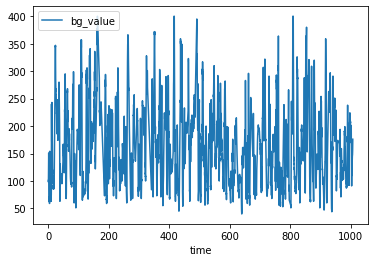

2021-07-07 17:18:19.563 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-07 17:18:19.567 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_6_6.pkl


Index(['bg_value__variance_larger_than_standard_deviation',
       'bg_value__has_duplicate_max', 'bg_value__has_duplicate_min',
       'bg_value__has_duplicate', 'bg_value__sum_values',
       'bg_value__abs_energy', 'bg_value__mean_abs_change',
       'bg_value__mean_change', 'bg_value__mean_second_derivative_central',
       'bg_value__median',
       ...
       'bg_value__permutation_entropy__dimension_6__tau_1',
       'bg_value__permutation_entropy__dimension_7__tau_1',
       'bg_value__query_similarity_count__query_None__threshold_0.0',
       'bg_value__matrix_profile__feature_"min"__threshold_0.98',
       'bg_value__matrix_profile__feature_"max"__threshold_0.98',
       'bg_value__matrix_profile__feature_"mean"__threshold_0.98',
       'bg_value__matrix_profile__feature_"median"__threshold_0.98',
       'bg_value__matrix_profile__feature_"25"__threshold_0.98',
       'bg_value__matrix_profile__feature_"75"__threshold_0.98', 'label'],
      dtype='object', length=788)
Pipelin

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,32.7582,2357.2875,46.6166,0.5256,0.285,0.2455,1.031


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,32.7582,2357.2875,46.6166,0.5256,0.285,0.2455,1.031
lasso,Lasso Regression,20.6598,9693.1158,60.8968,-0.9290,0.194,0.1387,0.697


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,32.7582,2357.2875,46.6166,0.5256,0.2850,0.2455,1.031
ridge,Ridge Regression,20.4481,8427.9119,59.1283,-0.6797,0.1986,0.1364,0.054
lasso,Lasso Regression,20.6598,9693.1158,60.8968,-0.9290,0.1940,0.1387,0.697


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,32.7582,2357.2875,46.6166,0.5256,0.2850,0.2455,1.031
en,Elastic Net,20.5132,7798.5897,57.6237,-0.5542,0.1911,0.1376,0.737
ridge,Ridge Regression,20.4481,8427.9119,59.1283,-0.6797,0.1986,0.1364,0.054
lasso,Lasso Regression,20.6598,9693.1158,60.8968,-0.9290,0.1940,0.1387,0.697


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
par,Passive Aggressive Regressor,5.940383e+02,1.264251e+08,5.037290e+03,-2.383563e+04,0.9787,5.156300e+00,0.083
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
huber,Huber Regressor,1.543242e+02,7.025017e+04,2.226921e+02,-1.304160e+01,4.2543,9.319000e-01,0.934
par,Passive Aggressive Regressor,5.940383e+02,1.264251e+08,5.037290e+03,-2.383563e+04,0.9787,5.156300e+00,0.083
lar,Least Angle Regression,1.290786e+11,6.456890e+23,2.750301e+11,-1.246577e+20,14.4625,8.947051e+08,0.121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.303870e+01,1.093305e+03,3.303920e+01,7.784000e-01,0.2143,1.576000e-01,0.547
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
huber,Huber Regressor,1.543242e+02,7.025017e+04,2.226921e+02,-1.304160e+01,4.2543,9.319000e-01,0.934
par,Passive Aggressive Regressor,5.940383e+02,1.264251e+08,5.037290e+03,-2.383563e+04,0.9787,5.156300e+00,0.083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.303870e+01,1.093305e+03,3.303920e+01,7.784000e-01,0.2143,1.576000e-01,0.547
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
dt,Decision Tree Regressor,2.587580e+01,1.477138e+03,3.836450e+01,7.004000e-01,0.2391,1.722000e-01,0.523
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050
huber,Huber Regressor,1.543242e+02,7.025017e+04,2.226921e+02,-1.304160e+01,4.2543,9.319000e-01,0.934


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.824620e+01,7.277865e+02,2.694590e+01,8.523000e-01,0.1716,1.226000e-01,1.840
knn,K Neighbors Regressor,2.303870e+01,1.093305e+03,3.303920e+01,7.784000e-01,0.2143,1.576000e-01,0.547
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
dt,Decision Tree Regressor,2.587580e+01,1.477138e+03,3.836450e+01,7.004000e-01,0.2391,1.722000e-01,0.523
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.824620e+01,7.277865e+02,2.694590e+01,8.523000e-01,0.1716,1.226000e-01,1.840
knn,K Neighbors Regressor,2.303870e+01,1.093305e+03,3.303920e+01,7.784000e-01,0.2143,1.576000e-01,0.547
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
dt,Decision Tree Regressor,2.587580e+01,1.477138e+03,3.836450e+01,7.004000e-01,0.2391,1.722000e-01,0.523
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.824620e+01,7.277865e+02,2.694590e+01,8.523000e-01,0.1716,1.226000e-01,1.840
knn,K Neighbors Regressor,2.303870e+01,1.093305e+03,3.303920e+01,7.784000e-01,0.2143,1.576000e-01,0.547
omp,Orthogonal Matching Pursuit,1.963910e+01,1.740254e+03,3.660250e+01,6.415000e-01,0.1897,1.324000e-01,0.049
dt,Decision Tree Regressor,2.587580e+01,1.477138e+03,3.836450e+01,7.004000e-01,0.2391,1.722000e-01,0.523
lr,Linear Regression,3.275820e+01,2.357287e+03,4.661660e+01,5.256000e-01,0.2850,2.455000e-01,1.031
br,Bayesian Ridge,2.015490e+01,3.850822e+03,4.795070e+01,2.275000e-01,0.1905,1.351000e-01,0.405
en,Elastic Net,2.051320e+01,7.798590e+03,5.762370e+01,-5.542000e-01,0.1911,1.376000e-01,0.737
ridge,Ridge Regression,2.044810e+01,8.427912e+03,5.912830e+01,-6.797000e-01,0.1986,1.364000e-01,0.054
lasso,Lasso Regression,2.065980e+01,9.693116e+03,6.089680e+01,-9.290000e-01,0.1940,1.387000e-01,0.697
llar,Lasso Least Angle Regression,5.783280e+01,4.952086e+03,7.035260e+01,-2.300000e-03,0.4430,4.324000e-01,0.050


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.4779,696.7854,26.3967,0.8522,0.1721,0.1218
1,18.4137,712.7493,26.6974,0.8624,0.1662,0.1241
2,18.1875,667.4991,25.8360,0.8588,0.1698,0.1234
3,19.3540,836.8778,28.9288,0.8338,0.1785,0.1249
4,17.4128,630.4542,25.1088,0.8763,0.1573,0.1131
5,18.9953,765.9859,27.6765,0.8561,0.1755,0.1259
6,18.8233,776.1133,27.8588,0.8395,0.1800,0.1311
7,18.3654,752.3999,27.4299,0.8456,0.1754,0.1243
8,17.2212,622.9730,24.9594,0.8767,0.1633,0.1176
9,18.2113,816.0274,28.5662,0.8215,0.1775,0.1202


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.4779,696.7854,26.3967,0.8522,0.1721,0.1218
1,18.4137,712.7493,26.6974,0.8624,0.1662,0.1241
2,18.1875,667.4991,25.8360,0.8588,0.1698,0.1234
3,19.3540,836.8778,28.9288,0.8338,0.1785,0.1249
4,17.4128,630.4542,25.1088,0.8763,0.1573,0.1131
5,18.9953,765.9859,27.6765,0.8561,0.1755,0.1259
6,18.8233,776.1133,27.8588,0.8395,0.1800,0.1311
7,18.3654,752.3999,27.4299,0.8456,0.1754,0.1243
8,17.2212,622.9730,24.9594,0.8767,0.1633,0.1176
9,18.2113,816.0274,28.5662,0.8215,0.1775,0.1202


2021-07-07 17:20:41.226 | INFO     | __main__:run:58 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18.3224,722.099,26.8719,0.8573,0.1728,0.1247


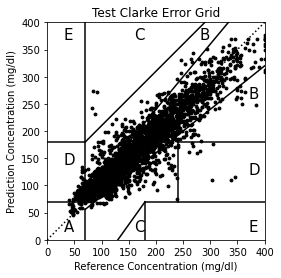

2021-07-07 17:20:42.496 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_6.pkl
2021-07-07 17:20:42.549 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


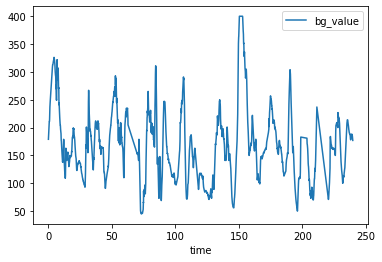

2021-07-07 17:20:42.996 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-07 17:20:42.998 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_6.pkl


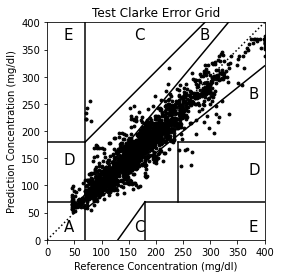

[{'patient': 559,
  'window': '6(30 minutes)',
  'horizon': '6(30 minutes)',
  'model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=1974, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
  'model_name': 'LGBMRegressor',
  'internal_cga_analysis': [2628, 497, 4, 107, 0],
  'internal_rmse': 26.871900697137704,
  'internal_rmadex': 2963.7263025888333,
  'unseen_cga_analysis': [2223, 246, 6, 28, 0],
  'unseen_rmse': 22.239868912564415,
  'unseen_rmadex': 178.93879869043914}]

In [3]:
patients = [559]
windows = [6]
horizons = [6]
[run(patient,window, horizon) for patient in patients for window in windows for horizon in horizons]